# Deep Learning with PyTorch II (nn, mnist)
Second part of deep learning with PyTorch. 
- Part 1: 

## 1. Introduction
In this notebook we'll explore how to build a simple neural network architecture (multilayer perceptron) in PyTorch and how to preprocess the mnist image data. The objective is to predict a handwritten number from a 28x28 pixel image with a neural network.

#### Neural Networks in PyTorch
PyTorch has a function `nn` that provides a nice way to efficiently build large neural networks. 

In [1]:
# Standard imports
import numpy as np 
import matplotlib.pyplot as plt

# Import visualization function
import helper

# torch import
import torch
from torch import nn
import torch.nn.functional as F

# data
from torchvision import datasets, transforms

# specify visualizations
%matplotlib inline 
%config InlineBackend.figure_format = "retina"

## 2. The data
For demonstration we will use the [mnist](https://en.wikipedia.org/wiki/MNIST_database) of handwritten numbers. 

- We have to normalize the data using `transforms.Compose()`.
 - Before downloading the data, we define how we want to transform the downloaded data in `transform`.
 - [torchvision.transforms](https://pytorch.org/docs/master/torchvision/transforms.html)
- Using `datasets.MNIST` from `torchvision` to load the data, indicating the previously defined `transform`
 - [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html)
- `DataLoader` gives us a batch of 64 shuffled images .
 - [DataLoader](https://pytorch.org/docs/stable/data.html)

Each image consists of one handwritten number between 0-9, yielding 10 different classes:
<img src="images/mnist.png">

#### Import and process the data

In [2]:
# Define transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Import data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

# trainloader 
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True)


`trainloader` is an iterator. We can make use of an iterator with `iter(trainloader)` or use this in a standard for-loop trough the dataset:
```python
for image, label in trainloader:
    # do things with images and labels
```
- Here: Grab the first batch to check the data
- images is a tensor with size `(64,1,28,28)`. Hence 64 images per batch, 1 color channel, and 28x28 pixel images.

Shape of images:
 torch.Size([64, 1, 28, 28])

Shape of one image:
 torch.Size([1, 28, 28])


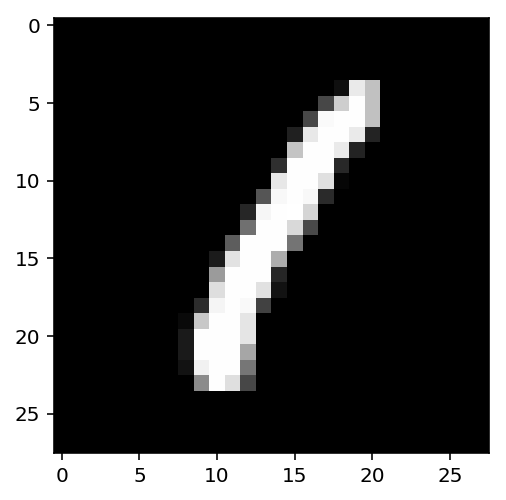

In [3]:
# one iteration = 64 images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Shape of images:\n", images.shape)
print("\nShape of one image:\n", images[0].shape)

# Show one image
plt.imshow(images[0].numpy().squeeze(), cmap = "Greys_r");

#### Data flattening and a first untrained network

Next step is to flatten the data in a way that our network can handle it. The network will be fully-connected (dense network), where each unit in one layer is connected to each unit in the next layer. 

In fully-connected networks, the input to each layer must be a one-dimensional vector. But our images are 28x28 pixels (2d Tensors), which must first be converted into 1d vectors of 784 input variables. We have to convert `(64,1,28,28)` to a shape of `(64, 784)`, which is called flattening the 2d to a 1d vector. Afterwards , we'll build a multilayer network with 784 input units, 256 hidden units and 10 output units (ten classes of numbers) starting with random tensors for the weights and biases. The activation function will a sigmoid function for the hidden layer.

To sum up:
- Convert `(64,1,28,28)` to a shape of `(64, 784)`
- Build neural network
 - input layer: 784
 - activation function: sigmoid
 - hidden layer: 256
 - output units: 10

In [4]:
# Define sigmoid activation function
def sigmoid(x):
    """Sigmoid activation function
    Inputs
    x: torch.Tensor
    ---------
    returns mapping of x 
    """
    return 1/(1+torch.exp(-x))

# reshape features
X = images.reshape(64, 784)
# images.reshape(64, -1) to fit appropriately

print("shape of X:\n", X.shape)

n_records = X.shape[0]
n_input = X.shape[1]
n_hidden = 256
n_output = 10 

# Input layer: weight matrices, random init
W1 = torch.randn(n_input, n_hidden)
B1 = torch.randn(n_hidden)
h = sigmoid(torch.mm(X, W1) + B1)
print("\nshape of W1:\n", W1.shape)
print("\nshape of dot product X * W1 = h:\n", h.shape)

# hidden layer: weight matrics, random init
W2 = torch.randn(h.shape[1], n_output)
B2 = torch.randn(n_output)
output = sigmoid(torch.mm(h, W2) + B2)

print("\nshape of W2:\n", W2.shape)
print("\nshape of B1:\n", B1.shape)
print("\nshape of output:\n", output.shape)

shape of X:
 torch.Size([64, 784])

shape of W1:
 torch.Size([784, 256])

shape of dot product X * W1 = h:
 torch.Size([64, 256])

shape of W2:
 torch.Size([256, 10])

shape of B1:
 torch.Size([256])

shape of output:
 torch.Size([64, 10])


#### Softmax activation function
Note that we have 10 output classes for our network. We would like to map those to a probability distribution over the classes with sum of probability over all classes equals one to tell us how likely the image belongs to a class. To do this we'll use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function), which also known as multinomial distribution function in statistics and is a generalization of the binary sigmoid function to account for multiple classes. 

The softmax function for two classes results in the sigmoid function. Mathematically this looks like: 

$$
\begin{align}
\Large \sigma(x_i) = \frac{e^{x_i}}{\sum_{k=1}^K{e^{x_k}}}
\end{align}
$$

This function squishes each input $x_i$ between 0 and 1 and normalizes the values to give a proper probability distribution where the probabilities sum up to one.

We'll now define the softmax function and map the output that we have calculated to a probability. Note that the model has not been trained yet (i.e. the weights are random) and therefore the resulting probabilities are not meaningful yet. Moreover, we matrix of probabilities for one batch of images. This means for every image we get a probability distribution for all ten classes.

In [5]:
# Softmax function 
def softmax(x):
    a = torch.exp(x) # Exponential of all 64 images
    b = torch.sum(a, dim=1).reshape(64,1) # sum of all rows
    y = a/b
    return y

# Apply softmax to output
props = softmax(output)
print("Probability of untrained network for first image:\n")

for i in range(len(props[0])):
    print("Probability of class"+str(i+1)+":\n "+str(props[0][i]))

Probability of untrained network for first image:

Probability of class1:
 tensor(0.1463)
Probability of class2:
 tensor(0.1463)
Probability of class3:
 tensor(0.1454)
Probability of class4:
 tensor(0.1462)
Probability of class5:
 tensor(0.0538)
Probability of class6:
 tensor(0.1463)
Probability of class7:
 tensor(0.0538)
Probability of class8:
 tensor(0.0538)
Probability of class9:
 tensor(0.0538)
Probability of class10:
 tensor(0.0541)


## 3. Building Networks in PyTorch
We'll use the module `nn` and its functions to build a neural network with the same properties as we have previously used, i.e.
- 784 input units + sigmoid activation
- 256 hidden units + sigmoid activation 
- 10 output units + softmax activation

One - in my opinion - very elegant solution is to create a new class, which is a concept of [Object-oriented programming (OOP)](https://realpython.com/python3-object-oriented-programming/).

We will create a new class, named `Network`. Note that ther are further options to use PyTorch for building a neural network which will be used later on.

In [6]:
# define classs
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # layers and activation functions
        self.hidden = nn.Linear(784, 256)
        self.output = nn.Linear(256, 10)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    
    # forward pass
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```
Here we're inheriting from `nn.Module`. 

Combined with `super().__init__()` this creates a class that tracks the architecture and provides useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here we define operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations, defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Now the input tensor `x` is passed through each operation a reassigned to `x` in a sequence of operations. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what the name of the variables are, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [7]:
# Initialize an object of the class
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

We can define the network possibly more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.

In [8]:
# Define class with nn.Module and F
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(784, 256)
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))
        x = F.softmax(self.output(x), dim=1)
        
        return x

#### Activation Functions 
We have already used some activation functions (e.g. sigmoid and 

<img src="images/activation_functions.png">

ReLu is almost exclusively used for hidden layers, whereas sigmoid is mostly used for binary classification and softmax for categorical classification and be used to ensure nonlinearity for the output.

The network that we've defined now for several times looks like the following 

<img src="images/neural_net.png">

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # defining layers
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
               
    def forward(self, x):
        ''' Forward pass though the net
        returns output '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

#### Initializing weights and biases
The weights are automatically initialized but it's possible to customize them. The weights and biases are tensors attached to the layer we defined and can be scaled using the following commands.

In [10]:
print(model.fc1.weight.shape) # Call weight for first layer
print(model.fc1.bias.shape) # Call Bias for first layer

## Modify them 
model.fc1.bias.data.fill_(0) # Set them to zero

# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

torch.Size([128, 784])
torch.Size([128])


tensor([[-0.0058, -0.0050,  0.0206,  ..., -0.0043, -0.0184,  0.0231],
        [ 0.0055, -0.0014, -0.0102,  ...,  0.0119,  0.0069, -0.0229],
        [ 0.0037, -0.0108,  0.0077,  ...,  0.0095,  0.0066,  0.0025],
        ...,
        [-0.0010,  0.0228, -0.0151,  ...,  0.0157,  0.0083,  0.0073],
        [-0.0031, -0.0107,  0.0140,  ..., -0.0056,  0.0221, -0.0043],
        [ 0.0162, -0.0184,  0.0040,  ...,  0.0009, -0.0077,  0.0072]])

#### Forward Pass

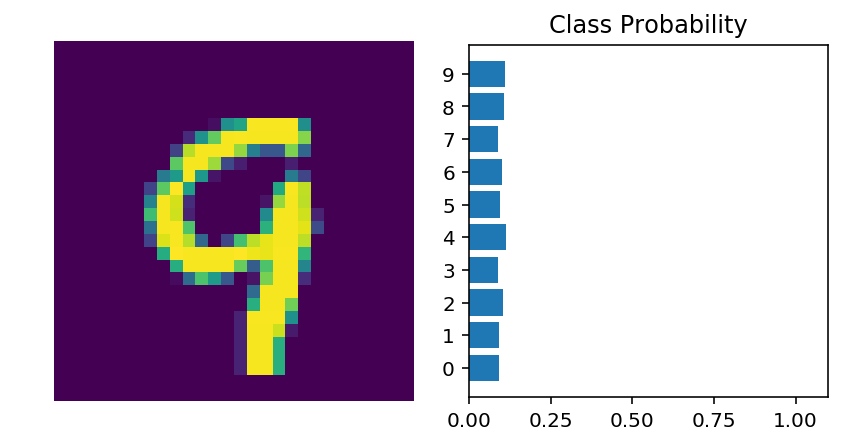

In [11]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector
# new shape is (batch size, color channels, 
#image pixels)
images.resize_(64, 1, 784)

# Forward pass through the network
img_idx = 0

# probability for image with index img_idx
ps = model.forward(images[img_idx,:])
img = images[img_idx]
helper.view_classify(img.view(1,28,28), ps)

Note that our network still has no idead what this digit is and the weights are random. The network requried training, which will be our next step.

#### Using `nn.Sequential`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network. 

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


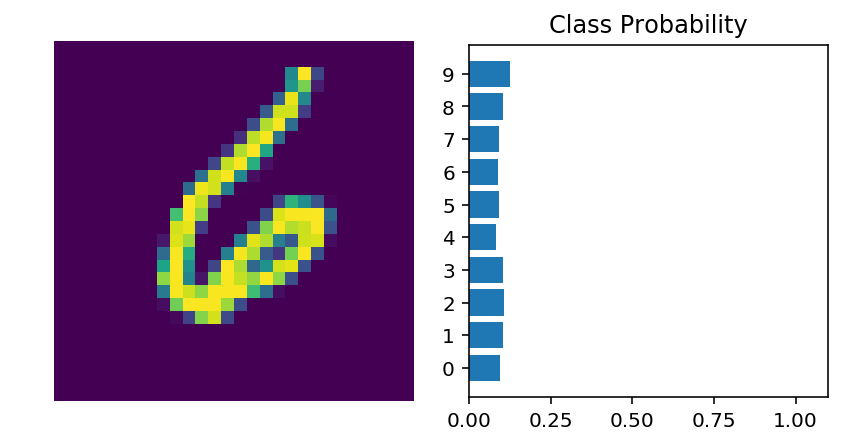

In [12]:
# Define input size, hidden layer and output size
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

In [13]:
# show first layer of the model and weight parameters
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[-1.8525e-02,  2.0407e-02, -2.7130e-03,  ..., -3.4824e-02,
          3.4488e-02, -5.9644e-03],
        [-1.1804e-02, -1.9799e-02, -1.7242e-02,  ...,  2.6892e-02,
         -1.6713e-02,  2.4640e-03],
        [-2.3732e-02, -4.9551e-03, -1.1314e-02,  ..., -3.3069e-02,
         -2.2066e-02, -8.9660e-04],
        ...,
        [ 1.4201e-02,  2.4515e-02, -5.0274e-03,  ...,  1.7684e-03,
          1.8343e-02,  1.6134e-02],
        [ 2.5678e-02,  2.2979e-02, -6.6634e-05,  ...,  2.7585e-02,
         -1.4235e-02, -2.4773e-02],
        [-9.6825e-03,  1.9159e-02,  1.3226e-02,  ...,  1.4671e-02,
         -2.1039e-02,  2.0243e-02]], requires_grad=True)

We can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so each operation must have a different name.

In [14]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))

print("Complete model:\n",model)
print("\nFirst layer:\n",model[0])

# Layers can be accessed by name
print("\nFirst layer (alternatively):\n",model.fc1)

Complete model:
 Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

First layer:
 Linear(in_features=784, out_features=128, bias=True)

First layer (alternatively):
 Linear(in_features=784, out_features=128, bias=True)
